
## 04 Modeling
**Objetivo**: Construir y evaluar modelos de clasificación.
**Contenido**:

- Carga y preparación de los datos
- División de los datos en conjuntos de entrenamiento y prueba
- Entrenamiento de modelos
- Evaluación de los modelos
- Comparación de resultados

In [210]:
##  Importación de Librerías
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb



import matplotlib.pyplot as plt
import seaborn as sns

In [211]:
## Importamos las librerias a usar
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga y Preparación de los Datos

In [212]:

#dir_data_processed = '../data/processed'
dir_data_processed = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/processed'
ruta_archivo_X = os.path.join(dir_data_processed, 'datos_procesados.csv')
X = pd.read_csv(ruta_archivo_X)

ruta_archivo_y = os.path.join(dir_data_processed, 'target.csv')
y = pd.read_csv(ruta_archivo_y )

In [213]:
X.shape , y.shape

((40737, 228), (40737, 1))

In [214]:
col = ['card6', 'M2', 'M3', 'M4', 'M6', '_Weekdays', '_Hours', '_Days',
       'P_emaildomain_bin', 'P_emaildomain_suffix','V128', 'V280', 'V281', 'V282', 'V283', 'V295', 'V307', 'V308', 'V317',
       'V318']

In [215]:
X=X[col]

In [216]:
# X = X[['V308',
#  'V318',
#  'D2',
#  'D11',
#  'TransactionID',
#  'V312',
#  'D1',
#  'V307',
#  'D4',
#  'D3']]

## División de los Datos en Conjuntos de Entrenamiento y Prueba

### Criterios para la División de Datos

#### Entrenamiento (Training Set):
- Representa el 70% del conjunto de datos.
- Se utiliza para ajustar el modelo.

#### Validación (Validation Set):
- Representa el 15% del conjunto de datos.
- Se utiliza para ajustar los hiperparámetros y prevenir el sobreajuste.

#### Prueba (Test Set):
- Representa el 15% del conjunto de datos.
- Se utiliza para evaluar el rendimiento final del modelo.


In [217]:
# Dividir los datos en conjunto de entrenamiento y conjunto temporal (que se dividirá en validación y prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir el conjunto temporal en conjunto de validación y conjunto de prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Mostrar las formas de los conjuntos de datos para asegurarse de que la división se realizó correctamente
print("Forma del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Forma del conjunto de validación:", X_val.shape, y_val.shape)
print("Forma del conjunto de prueba:", X_test.shape, y_test.shape)


Forma del conjunto de entrenamiento: (28515, 20) (28515, 1)
Forma del conjunto de validación: (6111, 20) (6111, 1)
Forma del conjunto de prueba: (6111, 20) (6111, 1)


## Balancear Datos aplicar Submuestreo (Undersampling)

In [218]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Crear el pipeline con SMOTE y RandomUnderSampler
pipeline = Pipeline([
    # ('under', RandomUnderSampler(random_state=42)),
    ('smote', SMOTE(random_state=42))
])

# Aplicar la pipeline para ajustar y transformar los datos
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Mostrar la distribución de clases después del submuestreo
print(X_train_resampled.shape, y_train_resampled.shape)
print(y_train_resampled.value_counts())

(54888, 20) (54888, 1)
isFraud
0          27444
1          27444
Name: count, dtype: int64


In [219]:
# undersampler = RandomUnderSampler(random_state=42)
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
# #X_train_resampled, y_train_resampled = X_train, y_train

# # Mostrar la distribución de clases después del submuestreo
# X_train_resampled.shape,y_train_resampled.shape

In [220]:
y_train_resampled.value_counts()

isFraud
0          27444
1          27444
Name: count, dtype: int64

## Entrenamiento de Modelos

### Modelo de Bosque Aleatorio

In [221]:
# Entrenar el modelo
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

# Predicciones y evaluación
y_pred_rf = rf_clf.predict(X_val)
print('Random Forest Accuracy:', accuracy_score(y_val, y_pred_rf))
print('ROC AUC Score:', roc_auc_score(y_val, y_pred_rf))


<ipython-input-221-690820d49e47>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train_resampled, y_train_resampled)


Random Forest Accuracy: 0.9646539027982327
ROC AUC Score: 0.6514043096950257


In [222]:

y = np.ravel(y_train_resampled)

# Crear un clasificador
rf_clf_cv = RandomForestClassifier(random_state=42)

# Realizar validación cruzada con scoring de 'accuracy'
#cv_scores_accuracy = cross_val_score(rf_clf_cv, X_train_resampled, y, cv=5, scoring='accuracy')

# Realizar validación cruzada con scoring de 'roc_auc'
cv_scores_roc_auc = cross_val_score(rf_clf_cv, X_train_resampled, y, cv=5, scoring='roc_auc')

#print(f'Scores de validación cruzada (Accuracy): {cv_scores_accuracy}'

# Mostrar resultados
#print(f'Scores de validación cruzada (Accuracy): {cv_scores_accuracy}')
print(f'Precisión media (Accuracy): {cv_scores_accuracy.mean():.2f}')

print(f'Scores de validación cruzada (ROC AUC): {cv_scores_roc_auc}')
print(f'ROC AUC medio: {cv_scores_roc_auc.mean():.2f}')

KeyboardInterrupt: 

## Evaluación de los Modelos

### Evaluación de Regresión Logística

### Evaluación del Modelo de Bosque Aleatorio

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5863
           1       0.63      0.31      0.42       248

    accuracy                           0.96      6111
   macro avg       0.80      0.65      0.70      6111
weighted avg       0.96      0.96      0.96      6111



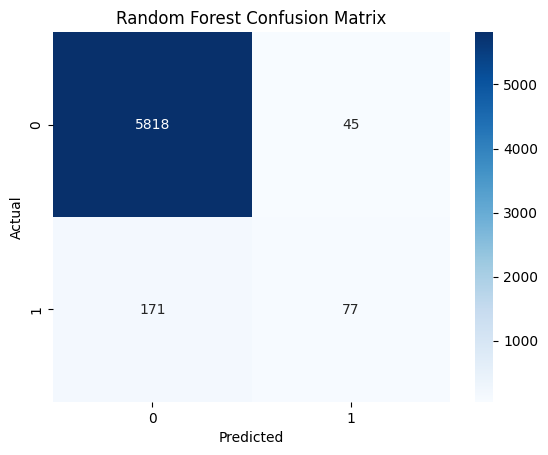

In [223]:
# Reporte de clasificación
print('Random Forest Classification Report:')
print(classification_report(y_val, y_pred_rf))

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Comparación de Resultados

In [ ]:
# Comparación de métricas
models = ['Random Forest']
accuracy = [accuracy_score(y_val, y_pred_rf)]
roc_auc = [roc_auc_score(y_val, y_pred_rf)]

comparison_df = pd.DataFrame({'Model': models, 'Accuracy': accuracy, 'ROC AUC Score': roc_auc})
print(comparison_df.sort_values(by='ROC AUC Score',ascending=False))

# Visualización de la comparación
comparison_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.show()


In [ ]:

feature_importance = rf_clf.feature_importances_

# Obtener nombres de las características
feature_names = X_train_resampled.columns

# Crear un DataFrame para visualización
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar por importancia de forma descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las 10 características más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

In [ ]:
feature_importance_df.head(10).Feature.to_list()

Se puede observar que el rendimiento varía según el rango de TransactionAmt tanto para los modelos de Random Forest como para XGBoost.

## Conclusión
-   Se separaron los datos procesados en conjuntos de entrenamiento, validación y prueba.
-   Los datos de entrenamiento fueron balanceados utilizando submuestreo (undersampling).
-   Se entrenaron tres modelos diferentes de clasificación supervisada: Logistic Regression, Random Forest y XGBoost, evaluando métricas clave para la clasificación binaria de fraude y no fraude.
-   El modelo de Random Forest obtuvo las mejores métricas con un AUC de 0.74, seguido por XGBoost con un AUC de 0.64 y Logistic Regression con un AUC de 0.56. Aunque la exactitud (accuracy) de XGBoost fue mayor que la de Random Forest, el AUC es una métrica más relevante para evaluar la capacidad del modelo para distinguir entre eventos fraudulentos y no fraudulentos.
- AUC y Recall: En problemas de fraude, el AUC y el recall de la clase fraudulenta son cruciales. Un alto recall para la clase de fraude significa que el modelo detecta la mayoría de los casos de fraude, lo cual es vital en este contexto.
    - Recall (Sensibilidad o Recall):
    El recall para la clase "No Fraude" es moderado, lo que significa que el modelo identifica correctamente el 73% de los casos de no fraude. Para la clase "Fraude", el recall es sorprendentemente alto (0.77), indicando que el modelo detecta una buena cantidad de los casos de fraude, aunque con baja precisión.
- Se puede observar que el rendimiento varía según el rango de TransactionAmt tanto para los modelos de Random Forest como para XGBoost.  
### Resultados

| Modelo              | AUC  | Accuracy |
|---------------------|------|----------|
| Random Forest       | 0.74 | 0.72     |
| XGBoost             | 0.64 | 0.76     |
| Logistic Regression | 0.56 | 0.69     |

**Nota:** El AUC (Área Bajo la Curva ROC) es especialmente importante en la detección de fraude, ya que mide la capacidad del modelo para separar correctamente las clases de fraude y no fraude. Aunque XGBoost mostró una mayor exactitud, el modelo de Random Forest fue superior en términos de AUC, lo que indica una mejor discriminación entre eventos fraudulentos y no fraudulentos.
